In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score


In [2]:
np.random.seed(42)
n = 5000

customers = pd.DataFrame({
    "customer_id": range(1, n+1),
    "tenure_months": np.random.randint(1, 72, n),
    "monthly_charges": np.random.randint(500, 5000, n),
    "total_usage_gb": np.random.randint(10, 1000, n),
    "support_tickets": np.random.randint(0, 10, n),
    "contract_type": np.random.choice(["Monthly", "Quarterly", "Yearly"], n),
    "payment_delay_days": np.random.randint(0, 60, n)
})

customers["churn"] = (
    (customers["payment_delay_days"] > 30) |
    (customers["support_tickets"] > 5) |
    (customers["tenure_months"] < 6)
).astype(int)

customers["revenue"] = customers["monthly_charges"] * customers["tenure_months"]
customers.head()


,customer_id,tenure_months,monthly_charges,total_usage_gb,support_tickets,contract_type,payment_delay_days,churn,revenue
0,1,52,1184,708,3,Yearly,43,1,61568
1,2,15,4129,527,1,Yearly,54,1,61935
2,3,61,3387,874,9,Monthly,26,1,206607
3,4,21,1962,359,0,Yearly,8,0,41202
4,5,24,4586,119,5,Yearly,45,1,110064


In [3]:
conn = sqlite3.connect("churn_analytics.db")
customers.to_sql("customers", conn, index=False, if_exists="replace")

pd.read_sql("SELECT COUNT(*) FROM customers", conn)


,COUNT(*)
0,5000


In [4]:
query = """
SELECT
    ROUND(AVG(churn)*100,2) AS churn_rate_pct
FROM customers
"""
pd.read_sql(query, conn)


,churn_rate_pct
0,70.8


In [5]:
query = """
SELECT
    contract_type,
    COUNT(*) AS customers,
    SUM(churn) AS churned,
    ROUND(AVG(churn)*100,2) AS churn_rate_pct
FROM customers
GROUP BY contract_type
"""
pd.read_sql(query, conn)


,contract_type,customers,churned,churn_rate_pct
0,Monthly,1661,1189,71.58
1,Quarterly,1698,1200,70.67
2,Yearly,1641,1151,70.14


In [6]:
query = """
SELECT
    SUM(revenue) AS total_revenue_lost
FROM customers
WHERE churn = 1
"""
pd.read_sql(query, conn)


,total_revenue_lost
0,337505629


In [7]:
query = """
SELECT
    customer_id,
    revenue,
    tenure_months,
    payment_delay_days,
    support_tickets
FROM customers
WHERE churn = 1
ORDER BY revenue DESC
LIMIT 20
"""
high_value_churn = pd.read_sql(query, conn)
high_value_churn


,customer_id,revenue,tenure_months,payment_delay_days,support_tickets
0,3898,347474,71,14,9
1,1265,346710,70,4,9
2,256,344103,69,16,6
3,1769,342007,71,41,1
4,734,341390,70,40,9
5,2502,338028,68,53,8
6,168,337890,70,47,1
7,3416,336030,69,50,0
8,2441,335510,70,26,8
9,2393,331062,69,46,3


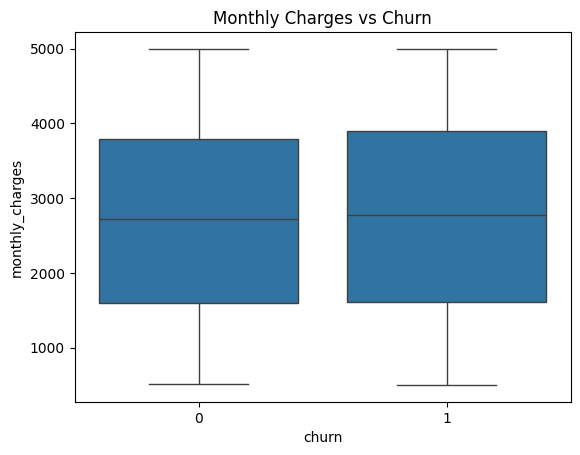

In [8]:
sns.boxplot(x="churn", y="monthly_charges", data=customers)
plt.title("Monthly Charges vs Churn")
plt.show()


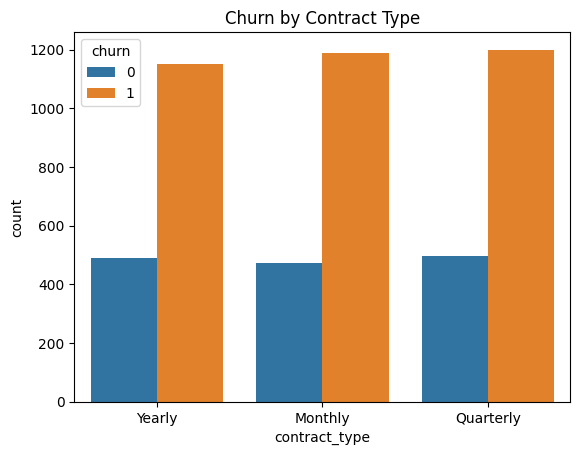

In [9]:
sns.countplot(x="contract_type", hue="churn", data=customers)
plt.title("Churn by Contract Type")
plt.show()


In [10]:
features = [
    "tenure_months",
    "monthly_charges",
    "support_tickets",
    "payment_delay_days"
]

X = customers[features]
y = customers["churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.84      0.80      0.82       455
           1       0.91      0.93      0.92      1045

    accuracy                           0.89      1500
   macro avg       0.88      0.87      0.87      1500
weighted avg       0.89      0.89      0.89      1500

ROC AUC: 0.9512382354487617


In [11]:
customers["churn_risk_score"] = model.predict_proba(
    scaler.transform(customers[features])
)[:,1]

customers.head()


,customer_id,tenure_months,monthly_charges,total_usage_gb,support_tickets,contract_type,payment_delay_days,churn,revenue,churn_risk_score
0,1,52,1184,708,3,Yearly,43,1,61568,0.933851
1,2,15,4129,527,1,Yearly,54,1,61935,0.981944
2,3,61,3387,874,9,Monthly,26,1,206607,0.990827
3,4,21,1962,359,0,Yearly,8,0,41202,0.014259
4,5,24,4586,119,5,Yearly,45,1,110064,0.996031


In [12]:
customers["risk_segment"] = pd.cut(
    customers["churn_risk_score"],
    bins=[0, 0.3, 0.6, 1.0],
    labels=["Low Risk", "Medium Risk", "High Risk"]
)

segment_revenue = customers.groupby("risk_segment")["revenue"].sum().reset_index()
segment_revenue


/tmp/ipython-input-1155211265.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_revenue = customers.groupby("risk_segment")["revenue"].sum().reset_index()


,risk_segment,revenue
0,Low Risk,107099331
1,Medium Risk,57395878
2,High Risk,326065932


In [13]:
customers.to_csv("customer_churn_final.csv", index=False)
high_value_churn.to_csv("high_value_churn.csv", index=False)
segment_revenue.to_csv("revenue_by_risk_segment.csv", index=False)


In [14]:
from google.colab import files
files.download("customer_churn_final.csv")
files.download("high_value_churn.csv")
files.download("revenue_by_risk_segment.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>